- https://github.com/AstraZeneca/skywalkR-graph-features

In [1]:
import numpy as np 
import pandas as pd
import anndata as ad
import screenpro

from screenpro.load import loadScreenProcessingData, read_adata_pkl

import sys
sys.path.append("/data_gilbert/home/aarab/FunGI")
from search import *

In [2]:
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm

from matplotlib import rcParams

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

### 

In [3]:
%load_ext rpy2.ipython

https://users.dimi.uniud.it/~massimo.franceschet/R/communities.html

https://kateto.net/netscix2016.html

In [4]:
%%R
library(igraph)
library(tidyverse)

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


___

In [5]:
import igraph as ig

In [6]:
help(filter_graph_by_weight)

Help on function filter_graph_by_weight in module search:

filter_graph_by_weight(G, weight_thr, side, verbose=True)
    subset graph by weight threshold



In [7]:
help(run_bfs)

Help on function run_bfs in module search:

run_bfs(graph, node, distance=1)
    Run BFS – Breadth-First Traversal (or Search)
    This function is running BFS algorithm to create a subgraph for given 1) `igraph` object, 2) node id, and 3) distance from the node.
    The subgraph includes all nodes with certain distance (defualt 1) from the given node.



In [8]:
def build_graph(df,verbose=True):

    out = ig.Graph.TupleList(df.itertuples(index=False), directed=False, weights=True)

    if verbose: get_graph_features(out)

    return out

In [9]:
def filter_graph_by_geneset(G, geneset, max_distance=1, verbose=True):
    """filter GI map by running BFS for given gene sets
    """
    bfs = []
    for gene in geneset:
        for distance in range(1, max_distance + 1):
            bfs = bfs + run_bfs(G, gene, distance=distance)
    
    outG = G.vs.select(name_in=bfs + geneset).subgraph()
    
    if verbose: get_graph_features(outG)
    
    return outG

In [10]:
def plot_graph(G, geneset=None, geneset2=None, layout="kk", b1=500, b2=500):
    """visualising graph data
    """
    G.vs["color"] = ["lightgray" for vertex in G.vs] 

    if geneset: 
        for gene in geneset:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = 'yellow'
            
    if geneset2: 
        for gene in geneset2:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = "lightblue"

    return ig.plot(
        G,
        layout=G.layout(layout),
        vertex_label=G.vs["name"],
        vertex_color=G.vs["color"],
        vertex_label_size=6, 
        vertex_size=35,
        edge_arrow_size = 0.5,
        edge_arrow_width = 2,
        bbox=(b1, b2), margin=60,
    )

### Get phenotype scores

In [11]:
Ci_adata = read_adata_pkl('datasets/CRISPRi')
Ca_A549_adata = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562_adata = read_adata_pkl('datasets/CRISPRa_k562')

In [12]:
def get_annotated_score_df(adata,score,level,threshold):
    if level == 'transcript':
        df = adata.transcript_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').reset_index(drop=True).copy()
    
    elif level == 'gene':
        df = adata.gene_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').copy()
        
    df = screenpro.phenoScore.ann_score_df(df, ctrl_label='pseudo',threshold=threshold)
    
    return df

In [13]:
screenpro.phenoScore.ann_score_df

<function screenpro.phenoScore.ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', ctrl_label='non-targeting', threshold=10)>

In [14]:
threshold = 2

In [15]:
rho_dict = dict([
    (treat,get_annotated_score_df(Ci_adata,score,'gene',threshold = threshold).set_index('target')) for treat, score in Ci_adata.comparisons.items()
])

In [16]:
rho_df = pd.concat(dict([(treat,rho.score) for treat, rho in rho_dict.items()]),axis=1)
# rho_df = pd.concat(rho_dict,axis=1)

rho_label = pd.concat(dict([(treat,rho.label) for treat, rho in rho_dict.items()]),axis=1)

In [17]:
rho_bin = pd.DataFrame(0,index=rho_label.index,columns=rho_label.columns)

rho_bin = (rho_label.isin(['sensitivity_hit']) * -1) + (rho_label.isin(['resistance_hit']) * 1)

# rho_bin = rho_bin[~rho_bin.eq(0).sum(axis=1).eq(9)]

### geneset!

In [18]:
gesa_res = pd.concat(dict([
    (treat, pd.read_excel('results/go_gsea.xlsx',index_col=0,header=0,sheet_name=f'CRISPRi {treat}')['es'])
    for treat in Ci_adata.comparisons.keys()
]),axis=1).fillna(0)

### PCC graph
Pearson’s correlation coefficient (PCC) `gene-gene-cor` graph

> #### A Genetic Map of the Response to DNA Damage in Human Cells
> The similarity in profiles of genes having related function (e.g.,
XRCC4 and LIG4 or ERCC6 and ERCC8) prompted us to undertake similarity profiling based on their Pearson correlation coefficient (PCC). This allowed us to build a network where genes are
nodes, and their edges are constrained by their PCC values

> - https://doi.org/10.1016/j.cell.2020.05.040


In [19]:
# exclude neg-ctrl signal
rho_df_1 = rho_df[~rho_df.index.str.contains('pseudo')].copy()

# exclude genes if they are non-hit in all screens
rho_df_2 = rho_df_1[~rho_label[~rho_df.index.str.contains('pseudo')].eq('target_non_hit').sum(axis=1).eq(9)].copy()

# get gene level corr values
rho_target_corr = rho_df_2.T.corr()
rho_target_corr.columns.name = None

In [20]:
# make the graph table
rho_target_corr_gr_table0 = rho_target_corr.reset_index().melt(
    id_vars=['target'],var_name=['target2']
)

<div class="alert alert-block alert-info"> <b>NOTE</b> `target` and `target2` are target genes from a single targeting CRISPR platform. These are just named for Pearson’s correlation coefficient (PCC) graph analysis. </div>

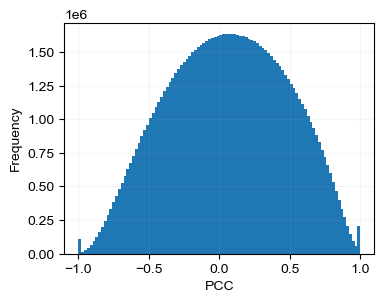

In [21]:
rho_target_corr_gr_table0.value.hist(bins=100,figsize=(4,3))
plt.xlabel('PCC')
plt.ylabel('Frequency')
plt.grid('off', alpha=0.1) 
plt.show() 

#### filter

In [22]:
rho_target_corr_gr_table = rho_target_corr_gr_table0.query("value > 0.9 & target != target2").reset_index(drop=True)

In [23]:
# rho_target_corr_gr_table.value.hist(bins=100,figsize=(4,3))
# plt.xlabel('PCC')
# plt.ylabel('Frequency')
# plt.grid('off', alpha=0.1) 
# plt.show() 

In [24]:
rho_target_corr_gr = build_graph(rho_target_corr_gr_table)

IGRAPH UNW- 10035 702798 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 10035
Number of edges in the graph 702798
Is the graph directed: False
Maximum degree in the graph: 13146
Node name with Maximum degree: ['ANLN', 'GAR1', 'NOP2', 'POLR2H', 'RPS13', 'UTP20']


In [25]:
help(filter_graph_by_weight)

Help on function filter_graph_by_weight in module search:

filter_graph_by_weight(G, weight_thr, side, verbose=True)
    subset graph by weight threshold



In [26]:
rho_target_corr_gr_prdx1 = filter_graph_by_geneset(
    rho_target_corr_gr,
    geneset=['PRDX1'],
    max_distance=1
)

IGRAPH UNW- 30 382 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 30
Number of edges in the graph 382
Is the graph directed: False
Maximum degree in the graph: 58
Node name with Maximum degree: ['PRDX1']


In [27]:
# plot_graph(
#     rho_target_corr_gr_prdx1.simplify(),
#     geneset=['PRDX1'],
#     # geneset2 = list(set(rho_phenotypes.vs['name']) - set(['ctrlcontext']) ),
#     layout='kk', b1=600,b2=450)

___

In [199]:
keep = rho_target_corr_gr_prdx1.vs['name']

In [288]:
d = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
d.columns = ['V1','V2','weight']

### PARPi

In [310]:
treat = 'PARPi+WEE1i'

In [311]:
s = rho_df.loc[keep,[treat]].fillna(0).abs()

In [312]:
l = rho_label.loc[keep,[treat]].replace({treat: {
    'target_non_hit': 'grey30', 
    'resistance_hit': '#de2d26', 
    'sensitivity_hit': "#3182bd", 
}}).astype(str)

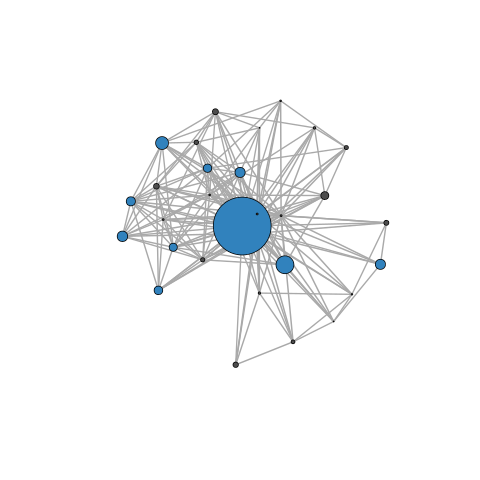

In [317]:
%%R -i d,s,l
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

V(g)$color <- l[V(g)$name,]
E(g)$width <- E(g)$weight 

coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     vertex.size=abs(s[V(g)$name,] * 20)
    )

In [293]:
%%R
is_weighted(g)

[1] TRUE


___

In [172]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [233]:
%%R
c2 = cluster_leading_eigen(g)

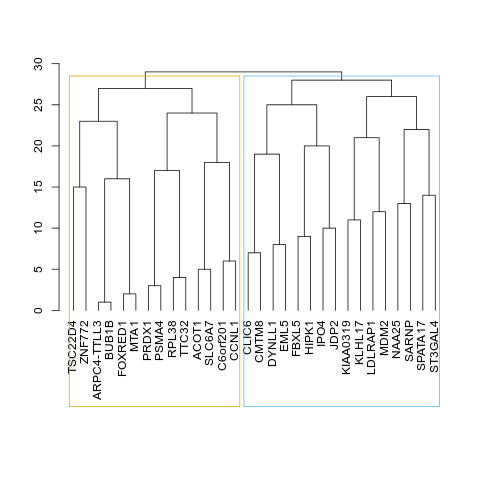

In [259]:
%%R
igraph::plot_dendrogram(c2)

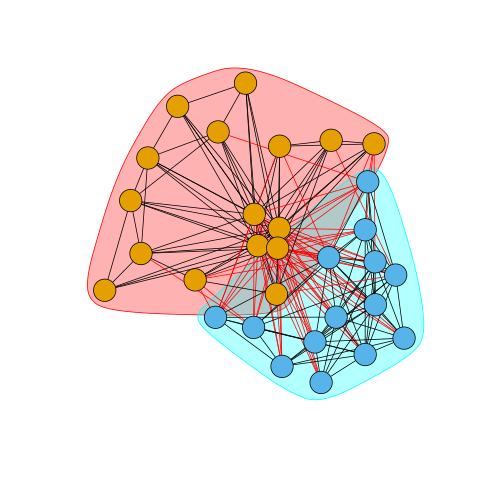

In [260]:
%%R 
plot(c2, g, 
     layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     # vertex.size=abs(s[V(g)$name,] * 20)
    )

### 
<!-- GTP graph -->
`Gene-Treatment-PhenotypeScore` wighted graph

___
build graph

In [ ]:
# gr_table = pd.concat([
#     rho_df.reset_index().melt(id_vars=['target'],value_name='score',var_name='treatment').set_index(['target','treatment']),
#     rho_label.reset_index().melt(id_vars=['target'],var_name='treatment',value_name='label').set_index(['target','treatment'])
# ],axis=1).query('label != "pseudo" and label != "target_non_hit"')

In [ ]:
# gr = build_graph(gr_table.drop(columns='label').reset_index())

___
combine

In [ ]:
# keep = rho_target_corr_gr_prdx1.vs['name']

In [ ]:
# d1 = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
# d1.columns = ['col_1','col_2','value']
# d1['edgeType'] = 'PCC'

# d2 = gr_table.drop(columns='label').reset_index().query(f'target in {keep}').reset_index(drop=True)
# d2.columns = ['col_1','col_2','value']
# d2['edgeType'] = 'GTP'

# d = pd.concat([d1,d2],axis=0).reset_index(drop=True)

In [ ]:
# %%R -i d

# d %>% head

In [ ]:
# %%R
# g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
# g = igraph::simplify(g)

In [ ]:
# %%R
# coords = layout_with_fr(g)
# # plot the graph
# plot(igraph::simplify(g), layout=coords, vertex.label=NA, vertex.size=10)

In [ ]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [ ]:
# %%R
# c2 = cluster_leading_eigen(g)

In [ ]:
# %%R
# igraph::plot_dendrogram(c2)

In [ ]:
# %%R 
# plot(c2, g, layout=coords, vertex.color=membership(c1),vertex.label=NA, vertex.size=10)

In [ ]:
# %%R
# plot(g, vertex.color=membership(c2), layout=coords)

# 

In [ ]:
%%R
sessionInfo()

In [ ]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)